# Traveling Salesman Problem (TSP) solved with Genetic Algorithms.

The Traveling Salesman Problem is a classic optimization problem that has as objective to calculate the most efficient
way to visit N cities with minimum travelled distance.

We will use a basic genetic algorithm to solve this problem by finding an optimum solution.

Also, we will use the DEAP library to solve this problem, more on this library on the following
[link.](https://deap.readthedocs.io)

First we need some imports:

In [1]:
import os
import pickle
import array
import csv
import codecs
import random
from urllib.request import urlopen
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Then we need to define a function to read the problem data, we will load data from the following site:
[http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/)

The following function fetch the data from the remote service and parses into a 2-dimensional array. We will use python
serialization to cache the data, so we don't overload the source site with requests.

In [2]:
URL_PREFIX = 'http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/'


def read_tsp_data(tsp_name):
    """
    This function reads the tsp problem sample into an array of coordinates.
    :param tsp_name: the tsp problem name.
    :return: a 2-dimensional array with the city coordinates.
    """
    try:
        locations = pickle.load(open(os.path.join('tsp-data', tsp_name + '-loc.pickle'), 'rb'))
        distances = pickle.load(open(os.path.join('tsp-data', tsp_name + '-dist.pickle'), 'rb'))
        return locations, distances
    except(OSError, IOError):
        pass

    locations = []
    # open url with tsp data
    tsp_url = URL_PREFIX + tsp_name + '.tsp'
    with urlopen(tsp_url) as f:
        # read the data as a csv file delimited with whitespaces (utf-8 character encoding)
        reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=' ', skipinitialspace=True)
        # ignore all the lines upto the start of the city coordinates
        for row in reader:
            if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                break
        for row in reader:
            # if we reach the end of the data exit
            if row[0] == 'EOF':
                break
            # delete the index, we need the coordinates only
            del row[0]
            locations.append(np.asarray(row, dtype=np.float32))

    # calculate distances using vector norm
    number_cities = len(locations)
    distances = [[0] * number_cities for _ in locations]
    for i in range(number_cities):
        for j in range(i + 1, number_cities):
            # vector norm
            distance = np.linalg.norm(locations[j] - locations[i])
            distances[i][j] = distances[j][i] = distance

    if not os.path.exists('tsp-data'):
        os.makedirs('tsp-data')
    pickle.dump(locations, open(os.path.join('tsp-data', tsp_name + '-loc.pickle'), 'wb'))
    pickle.dump(distances, open(os.path.join('tsp-data', tsp_name + '-dist.pickle'), 'wb'))
    return locations, distances

We will use 29 cities of Bavaria dataset.

In [3]:
CITIES, DISTANCES = read_tsp_data('bayg29')
NUMBER_CITIES = len(CITIES)

We need to define the algorithm hyper-parameters like:
- `NUM_GENERATIONS`: the number of generations that we will iterate applying
genetic algorithm operators to search for new optimal solutions.
- `POPULATION_SIZE`: the population size or how many potential solutions we will
use in each generation of the algorithm.
- `P_CROSSOVER`: the probability for an individual to be selected for crossover (mating)
- `P_MUTATION`: the probability for an individual to be selected for a random
mutation.

In [4]:
NUM_GENERATIONS = 1000
POPULATION_SIZE = 100
P_CROSSOVER = 0.9
P_MUTATION = 0.1

Next, we define the algorithm types, first the fitness type that will inherit
from the class `Fitness`, we need a negative weight because we are minimizing
the distance.
Also, we create an individual type, this will inherit from the python `list`
class, because we are going to represent the cities by using an ordered array
of city indexes to represent the solution, for example, if we have `10` cities,
we will have the following as a potential solution:

In [5]:
individual = list(range(NUMBER_CITIES))
individual = random.sample(individual, len(individual))
print(individual)

[9, 24, 25, 5, 26, 23, 10, 2, 17, 1, 21, 28, 22, 6, 4, 18, 7, 3, 15, 16, 13, 12, 19, 11, 27, 8, 20, 0, 14]


We can now define a function to calculate the distances for a particular
instance of the problem.

In [6]:
def tsp_distance(individual: list) -> float:
    """
    Returns the traveling distance for particular ordering of cities.
    :param individual: an ordered list of cities to visit.
    :return: the total travelled distance.
    """
    # get distance between first and last city
    distance = DISTANCES[individual[0]][individual[-1]]
    # add all other distances
    for i in range(NUMBER_CITIES - 1):
        distance += DISTANCES[individual[i]][individual[i + 1]]
    return distance

In [7]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array.array, typecode='i', fitness=creator.FitnessMin)

In [8]:
toolbox = base.Toolbox()
# Create operator to shuffle the cities
toolbox.register('randomOrder', random.sample, range(NUMBER_CITIES), NUMBER_CITIES)
# Create initial random individual operator
toolbox.register('individualCreator', tools.initIterate, creator.Individual, toolbox.randomOrder)
# Create random population operator
toolbox.register('populationCreator', tools.initRepeat, list, toolbox.individualCreator)

In [9]:
def tspFitness(individual) -> tuple:
    return tsp_distance(individual),

In [10]:
toolbox.register('evaluate', tspFitness)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=1.0 / NUMBER_CITIES)

In [11]:
population = toolbox.populationCreator(n=POPULATION_SIZE)

A `HallOfFame` object is used to store the best individuals of each generation, we will use it to implement elitism.

In [12]:
HALL_OF_FAME_SIZE = 10
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

We use a `Statistics` object to track several statistics of the individuals.

In [13]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('max', np.max)
stats.register('avg', np.mean)

`Logbook` object is used to track each generation population statistics.

In [14]:
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

Evaluate the individuals with an invalid fitness

In [15]:
invalid_individuals = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

Update the hall of fame object with the initial population.

In [16]:
hof.update(population)
hof_size = len(hof.items)

Calculates statistics for the first generation.

In [17]:
record = stats.compile(population)
logbook.record(gen=0, nevals=len(invalid_individuals), **record)
print(logbook.stream)

gen	nevals	max    	avg    
0  	100   	31106.2	26489.9


In [18]:
for gen in range(1, NUM_GENERATIONS + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population) - hof_size)

    # Vary the pool of individuals
    offspring = algorithms.varAnd(offspring, toolbox, P_CROSSOVER, P_MUTATION)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # add the best back to population:
    offspring.extend(hof.items)

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    population[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)

1  	84    	28609.2	25073.7
2  	85    	28506.6	23777.9
3  	81    	26260.9	22567.1
4  	86    	25342.3	22022.1
5  	83    	28002  	21401.8
6  	81    	24348.4	20589.2
7  	83    	25963.5	20255.8
8  	80    	24484.5	19772  
9  	84    	23967.7	19186.5
10 	78    	22841.2	18499.2
11 	83    	24260.7	18275  
12 	86    	24461.9	18043.9
13 	84    	23326.8	17543.1
14 	89    	20836.3	17074  
15 	86    	21850.7	16801.2
16 	85    	22568.2	16194.9
17 	80    	19292  	15715.4
18 	86    	19004.7	15270  
19 	82    	20314.3	15297.3
20 	84    	19275.5	15149.5
21 	70    	18943.8	14908.9
22 	83    	19727.9	15091.5
23 	82    	20001  	14681.1
24 	85    	23566.6	15062.8
25 	86    	19099.6	14925.4
26 	81    	18627.5	14423.7
27 	86    	20743.5	14335.9
28 	83    	22547.9	14004.5
29 	83    	15816.7	13666.5
30 	80    	18766.8	13489.8
31 	88    	18604.1	13460.6
32 	84    	21430.4	13427.1
33 	81    	22329.6	13318.4
34 	78    	19417.2	13082.3
35 	87    	20416.6	13333.1
36 	80    	17230.3	13201.6
37 	86    	19002.2	13333.1
3

Best Individual =  Individual('i', [25, 2, 28, 1, 19, 9, 3, 14, 17, 13, 16, 21, 10, 18, 24, 6, 15, 12, 23, 26, 22, 7, 27, 0, 20, 4, 5, 11, 8])
Best Fitness =  9456.7822265625


<Figure size 432x288 with 0 Axes>

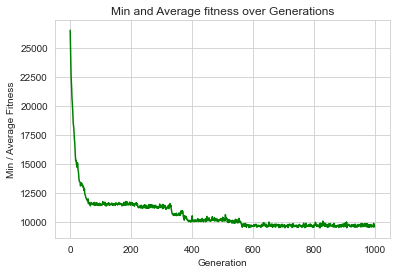

In [19]:
best = hof.items[0]
print('Best Individual = ', best)
print('Best Fitness = ', best.fitness.values[0])
plt.figure(1)

# plot statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')

# show both plots:
plt.show()